# Plot along-slope velocity for easterly simulations
The simulations run from '2150-01-01' to '2164-12-31'

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import xgcm
import xarray.ufuncs as xu

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/v45/akm157/figures/easterlies/perturbation_check/'

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:46731 Dashboard: /proxy/38835/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
easterlies_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

# plot anomalies for last 5 years of simulation:
start_time='2160-01-01'
end_time='2164-12-31'

lat_slice  = slice(-80,-58)

## Import data

Bathymetry

In [4]:
# topography data for plotting (on u-grid):
hu = cc.querying.getvar(control,'hu' , master_session,n=1)
land_mask = np.squeeze(hu.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

hu = hu.sel(yu_ocean=lat_slice)

ft_size=16

Load velocity (u and v component), upper 500 m

In [5]:
# Control
# u_con = cc.querying.getvar(control, 'u', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
# u_con = u_con.sel(yu_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time').sel(st_ocean=slice(0, 500)) 
# v_con = cc.querying.getvar(control, 'v', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
# v_con = v_con.sel(yu_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time').sel(st_ocean=slice(0, 500)) 

# Perturbation up
u_up = cc.querying.getvar(easterlies_up, 'u', easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) 
u_up = u_up.sel(yu_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time').sel(st_ocean=slice(0, 500))
v_up = cc.querying.getvar(easterlies_up, 'v', easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
v_up = v_up.sel(yu_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time').sel(st_ocean=slice(0, 500))

# Perturbation down
# u_down = cc.querying.getvar(easterlies_down, 'u', easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
# u_down = u_down.sel(yu_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time').sel(st_ocean=slice(0, 500))
# v_down = cc.querying.getvar(easterlies_down, 'v', easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
# v_down = v_down.sel(yu_ocean=lat_slice).sel(time=slice(start_time,end_time)).mean('time').sel(st_ocean=slice(0, 500))

Vertical average

In [8]:
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(control, 'st_edges_ocean', master_session, start_time=start_time, end_time=end_time, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean':u_up.yu_ocean,'xu_ocean':u_up.xu_ocean}, axis=[1,2])

# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(control, 'st_ocean', master_session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))
thickness = thickness

In [9]:
# u_con  = (u_con  * thickness).sum('st_ocean') / thickness.sum('st_ocean')
# v_con  = (v_con  * thickness).sum('st_ocean') / thickness.sum('st_ocean')
u_up   = (u_up   * thickness).sum('st_ocean') / thickness.sum('st_ocean')
v_up   = (v_up   * thickness).sum('st_ocean') / thickness.sum('st_ocean')
# u_down = (u_down * thickness).sum('st_ocean') / thickness.sum('st_ocean')
# v_down = (v_down * thickness).sum('st_ocean') / thickness.sum('st_ocean')

## Along-slope component

Topographic gradient

In [10]:
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

ds = xr.merge([hu, grid])
ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, periodic=['X'])

In [11]:
# Take gradient and move to u grid
# Simple gradient over one grid cell. 
# In latitudinal direction, we need to specify what happens at the boundary.
dhu_dx = grid.interp( grid.diff(ds.hu, 'X') / grid.interp(ds.dxu, 'X'), 'X')#, 'Y', boundary='extend')
dhu_dy = grid.interp( grid.diff(ds.hu, 'Y', boundary='extend') / grid.interp(ds.dyt, 'X'), 'Y', boundary='extend')# 'X')

# Select latitude slice
dhu_dx = dhu_dx.sel(yu_ocean=lat_slice)
dhu_dy = dhu_dy.sel(yu_ocean=lat_slice)

In [12]:
# Calculate the magnitude of the topographic slope
slope = xu.sqrt(dhu_dx**2 + dhu_dy**2)

Rotate

In [13]:
# u_along_con  = u_con*dhu_dy/slope - v_con*dhu_dx/slope
u_along_up   = u_up*dhu_dy/slope - v_up*dhu_dx/slope
# u_along_down = u_down*dhu_dy/slope - v_down*dhu_dx/slope

Load data

In [ ]:
u_along_con  = u_along_con.load()

In [14]:
u_along_up   = u_along_up.load()

In [15]:
u_along_down = u_along_down.load()

Save along-slope velocity (can skip the above steps next time and load in the post-processed data)

In [15]:
file_name_con = 'u_along_500m_con.nc'
#u_along_con.to_netcdf(file_name_con)
u_along_con = xr.open_dataset(file_name_con).__xarray_dataarray_variable__
#u_along_con = u_along_con.sel(yu_ocean=lat_slice)

In [26]:
file_name_up = 'u_along_500m_up.nc'
#u_along_up.to_netcdf(file_name_up)
#u_along_up = xr.open_dataset(file_name_up).__xarray_dataarray_variable__

In [16]:
file_name_down = 'u_along_500m_down.nc'
# u_along_down.to_netcdf(file_name_down)
u_along_down = xr.open_dataset(file_name_down).__xarray_dataarray_variable__

## Plot along-slope velocity perturbation:
Note that this is lazy time averaging (i.e. does not account for number of days in each month). This should be fixed for final paper figures.

In [36]:
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

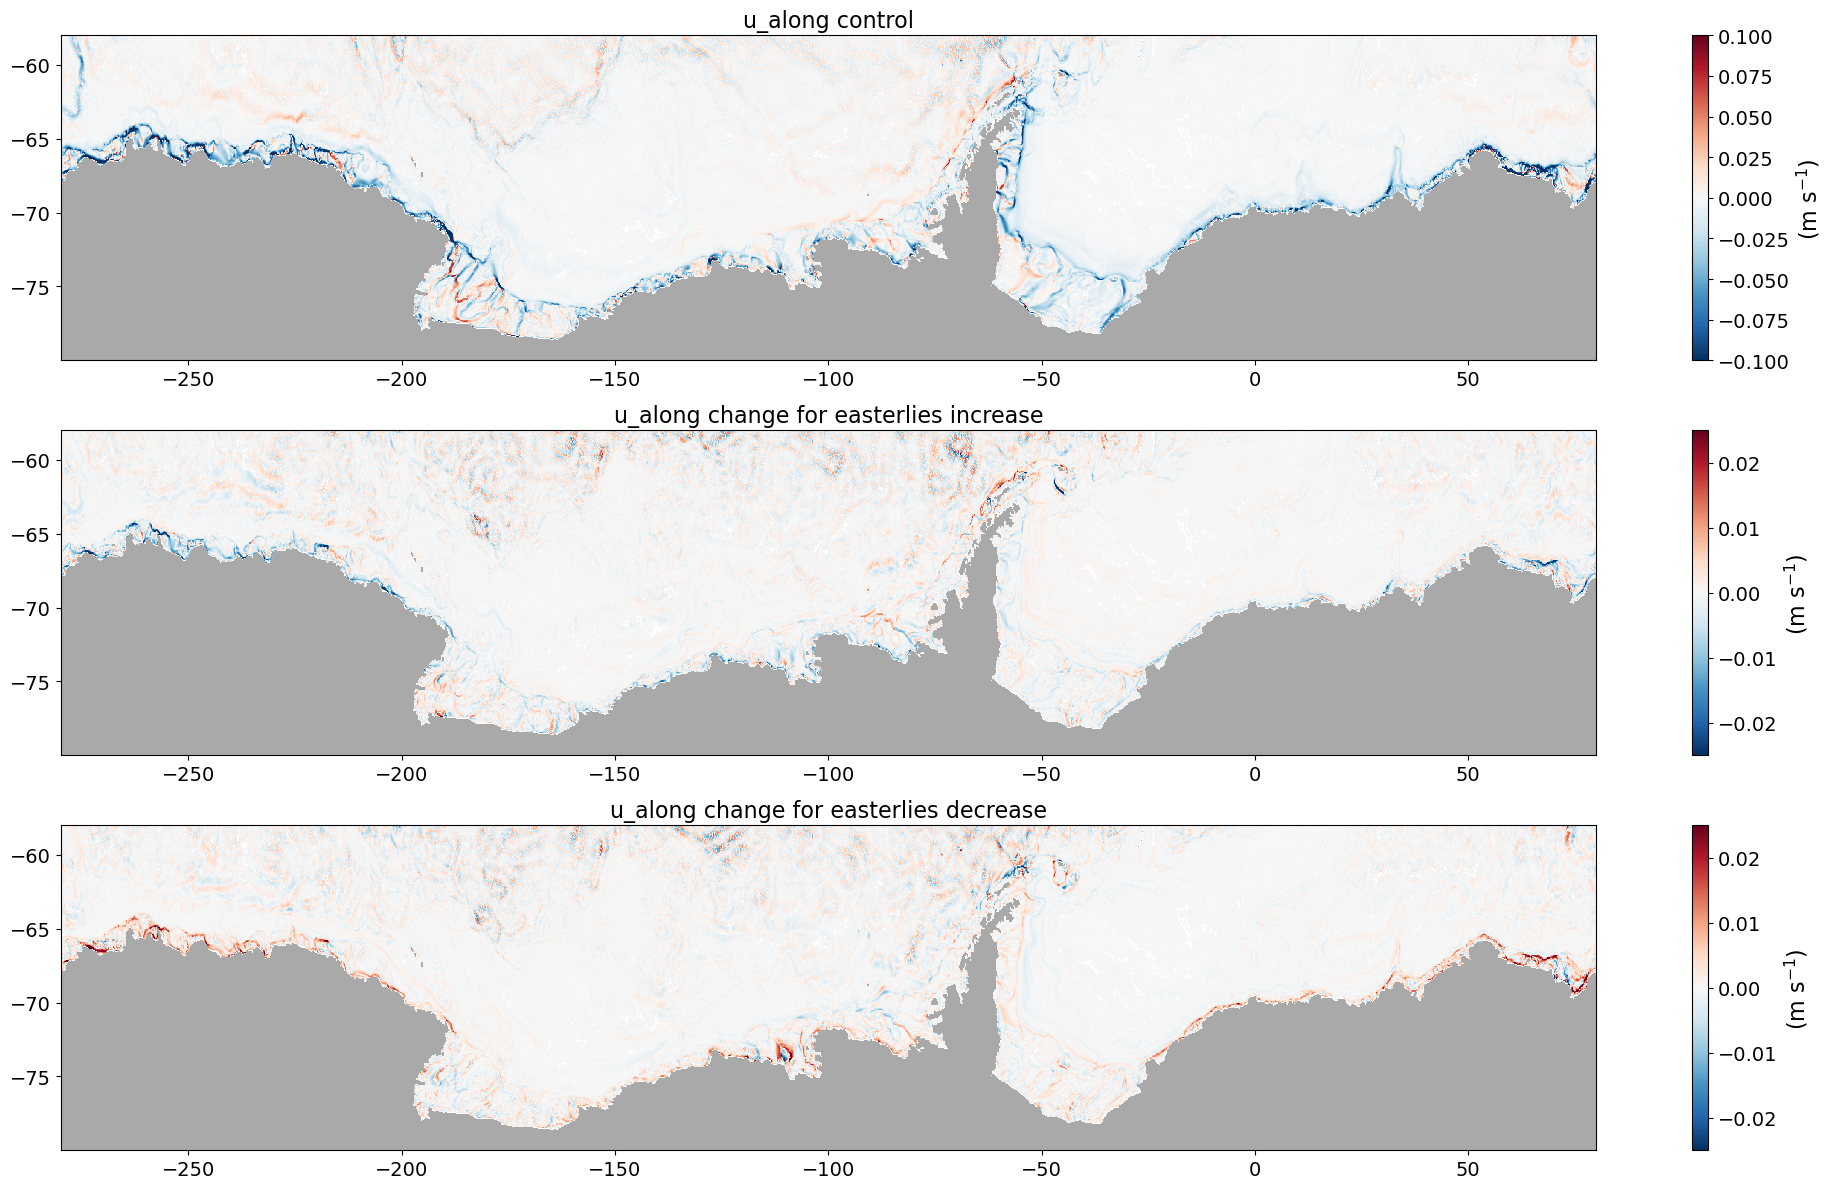

In [58]:
plt.figure(figsize=(20,12))

scale_max = 0.025

for ii in range(3):
    ax = plt.subplot(3,1,1+ii)
    if ii == 0:
        sc = plt.pcolormesh(hu.xu_ocean, hu.yu_ocean, u_along_con,vmin=-4*scale_max,vmax=4*scale_max,cmap='RdBu_r')
        plt.title('u_along control',fontsize=ft_size)
    elif ii == 1:
        sc = plt.pcolormesh(hu.xu_ocean, hu.yu_ocean, u_along_up - u_along_con,vmin=-scale_max,vmax=scale_max,cmap='RdBu_r')
        plt.title('u_along change for easterlies increase',fontsize=ft_size)
    elif ii == 2:
        sc = plt.pcolormesh(hu.xu_ocean, hu.yu_ocean, u_along_down - u_along_con,vmin=-scale_max,vmax=scale_max,cmap='RdBu_r')
        plt.title('u_along change for easterlies decrease',fontsize=ft_size)
    cbar = plt.colorbar(sc)
    cbar.ax.tick_params(labelsize=ft_size-2)
    cbar.set_label('(m s$^{-1}$)', fontsize=ft_size)
    plt.contourf(hu.xu_ocean, hu.yu_ocean, land_mask_masked, colors='darkgrey')
    #plt.contour(hu.xu_ocean,hu.yu_ocean,hu,levels=[1000,3000],colors='0.5')
    ax.tick_params(labelsize=ft_size-2)

plt.tight_layout()

save_fig = 1
if save_fig == 1:
    fig_name = 'Fig_ASC_map_easterlies_pert.png'
    plt.savefig(fig_name, dpi=150, bbox_inches='tight', facecolor='white')

Things to note:
- ASC is mostly negative, hence +ve anomalies indicate a slowdown of the ASC in the pertrubation and -ve anomalies an acceleration
- ASC accelerates for easterlies UP case
- ASC decelerates for easterlies DOWN case

---

Compare 5yr average (2160-2164) to 10 yr average (2080-2089) in control run. (Figure above looks different to Fig 2b in my manuscrip.)

In [14]:
s_time='2080-01-01'
e_time='2089-12-31'
# Load data
u_ryf = cc.querying.getvar(control, 'u', master_session,frequency='1 monthly',start_time=s_time, end_time=e_time)
u_ryf = u_ryf.sel(yu_ocean=lat_slice).sel(time=slice(s_time,e_time)).mean('time').sel(st_ocean=slice(0, 500)) 
v_ryf = cc.querying.getvar(control, 'v', master_session,frequency='1 monthly',start_time=s_time, end_time=e_time)
v_ryf = v_ryf.sel(yu_ocean=lat_slice).sel(time=slice(s_time,e_time)).mean('time').sel(st_ocean=slice(0, 500)) 
# Vertical average
u_ryf = (u_ryf   * thickness).sum('st_ocean') / thickness.sum('st_ocean')
v_ryf = (v_ryf   * thickness).sum('st_ocean') / thickness.sum('st_ocean')
# Along-slope component
u_along_ryf   = u_ryf*dhu_dy/slope - v_ryf*dhu_dx/slope

In [15]:
# Load data
u_along_ryf = u_along_ryf.load()

Circumpolar projection

In [16]:
import matplotlib.path as mpath
import cartopy.crs as ccrs

In [17]:
theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.455
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [18]:
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

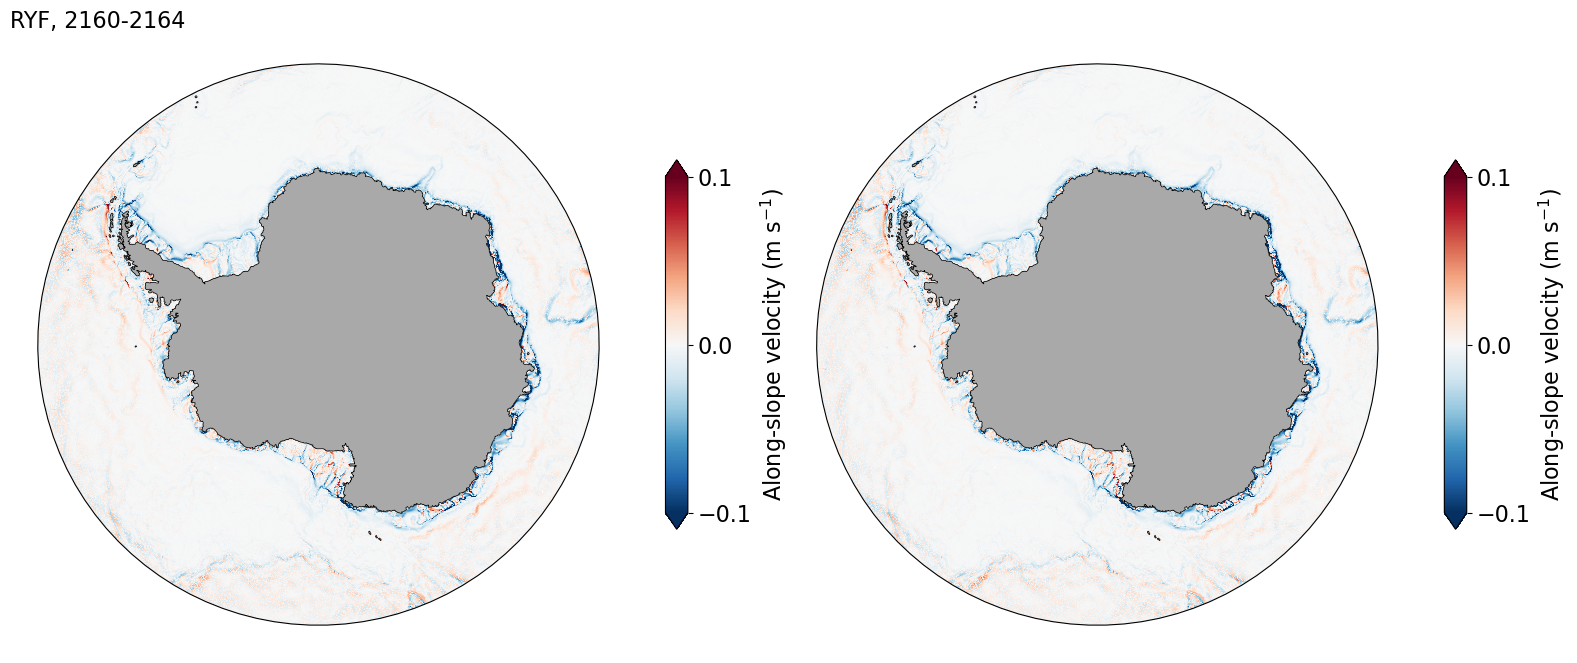

In [19]:
fig = plt.figure(1, figsize=(20,12))

for ii in range(2):
    ax = plt.subplot(1,2,1+ii, projection=ccrs.SouthPolarStereo())
    ax.set_boundary(circle, transform=ax.transAxes)

    if ii == 0:
        # Plot land
        ax.contourf(slope.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        ax.contour(slope.xu_ocean, slope.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        # Plot velocity
        plt.title('RYF, 2160-2164', fontsize=fontsize, loc='left')
        sc = ax.pcolormesh(slope.xu_ocean, slope.yu_ocean, u_along_con, transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.1, vmax=0.1)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both', ticks=np.arange(-0.2, 0.25, 0.1), aspect=15)
        cbar.set_label('Along-slope velocity (m s$^{-1}$)', fontsize=fontsize, labelpad=5)
        cbar.ax.tick_params(labelsize=fontsize)
        
    if ii == 1:
        # Plot land
        ax.contourf(slope.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        ax.contour(slope.xu_ocean, slope.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        # Plot velocity
        #plt.title('RYF, 2080-2089', fontsize=fontsize, loc='left')
        sc = ax.pcolormesh(slope.xu_ocean, slope.yu_ocean, u_along_ryf, transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.1, vmax=0.1)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both', ticks=np.arange(-0.2, 0.25, 0.1), aspect=15)
        cbar.set_label('Along-slope velocity (m s$^{-1}$)', fontsize=fontsize, labelpad=5)
        cbar.ax.tick_params(labelsize=fontsize)

plt.subplots_adjust(wspace=0.01)

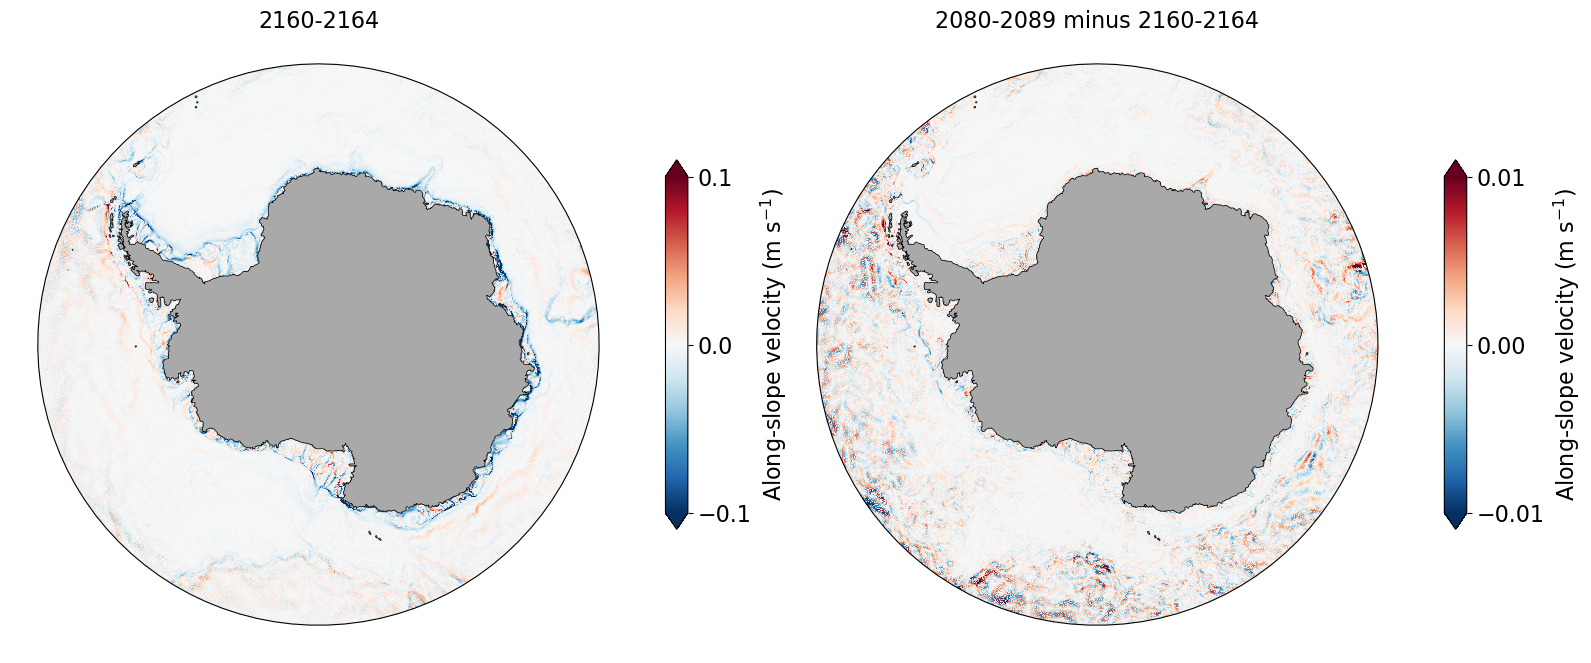

In [22]:
fig = plt.figure(1, figsize=(20,12))

for ii in range(2):
    ax = plt.subplot(1,2,1+ii, projection=ccrs.SouthPolarStereo())
    ax.set_boundary(circle, transform=ax.transAxes)

    if ii == 0:
        # Plot land
        ax.contourf(slope.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        ax.contour(slope.xu_ocean, slope.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        # Plot velocity
        plt.title('2160-2164', fontsize=fontsize)
        sc = ax.pcolormesh(slope.xu_ocean, slope.yu_ocean, u_along_con, transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.1, vmax=0.1)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both', ticks=np.arange(-0.2, 0.25, 0.1), aspect=15)
        cbar.set_label('Along-slope velocity (m s$^{-1}$)', fontsize=fontsize, labelpad=5)
        cbar.ax.tick_params(labelsize=fontsize)
        
    if ii == 1:
        # Plot land
        ax.contourf(slope.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        ax.contour(slope.xu_ocean, slope.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        # Plot velocity
        plt.title('2080-2089 minus 2160-2164', fontsize=fontsize)
        sc = ax.pcolormesh(slope.xu_ocean, slope.yu_ocean, u_along_ryf-u_along_con, transform = ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.01, vmax=0.01)
        cbar = plt.colorbar(sc, orientation='vertical', shrink=0.4, extend='both', ticks=np.arange(-0.02, 0.025, 0.01), aspect=15)
        cbar.set_label('Along-slope velocity (m s$^{-1}$)', fontsize=fontsize, labelpad=5)
        cbar.ax.tick_params(labelsize=fontsize)

plt.subplots_adjust(wspace=0.01)

---

Ideas:
- plot velocity at e.g. 200 m depth for the whole simulation to check interannual variability